# 공통

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
Device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(Device)

cuda:0


In [6]:
import zipfile

zip_file=zipfile.ZipFile("/content/drive/MyDrive/IOT/DATA/video.zip")
zip_file.extractall("/content/drive/MyDrive/IOT/DATA_Unzip")

In [ ]:
import os
import random
import fnmatch
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

print( f'np.__version__: {np.__version__}' )
print( f'pytorch.__version__: {torch.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image


np.__version__: 1.25.2
pytorch.__version__: 2.3.0+cu121


# NVIDIA 모델 ( 실주행때는 사용 X )


image_path: /content/drive/MyDrive/IOT/DATA_Unzip/video/train_05731_090.png
steering_Angle: 90


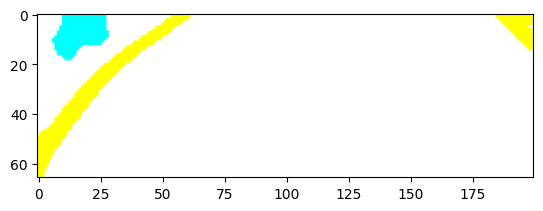

In [ ]:
data_dir = "/content/drive/MyDrive/IOT/DATA_Unzip/video"
file_list = os.listdir(data_dir)
image_paths = [] #이미지 경로를 저장하는 변수
steering_angles = [] #이미지 각도를 저장하는 변수
pattern = "*.png" #.png 확장자 가진 파일만 취급
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename)) #image_paths 리스트에 파일명을 추가한다.
        angle = int(filename[-7:-4]) #각도는 사진데이터에서 끝의 -7부터 -3까지만 분리한다.
     #예를들어 train_00006_090.png 파일명이라면 090만 분리하여 저장한다. .png도 파일명의 숫자로 포함 된다.
        steering_angles.append(angle) #steering_angles 리스트에 각도를 추가한다.

image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

(array([450.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 2406.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        2047.0000]),
 array([45.0000, 48.6000, 52.2000, 55.8000, 59.4000, 63.0000, 66.6000,
        70.2000, 73.8000, 77.4000, 81.0000, 84.6000, 88.2000, 91.8000,
        95.4000, 99.0000, 102.6000, 106.2000, 109.8000, 113.4000, 117.0000,
        120.6000, 124.2000, 127.8000, 131.4000, 135.0000]),
 <BarContainer object of 25 artists>)

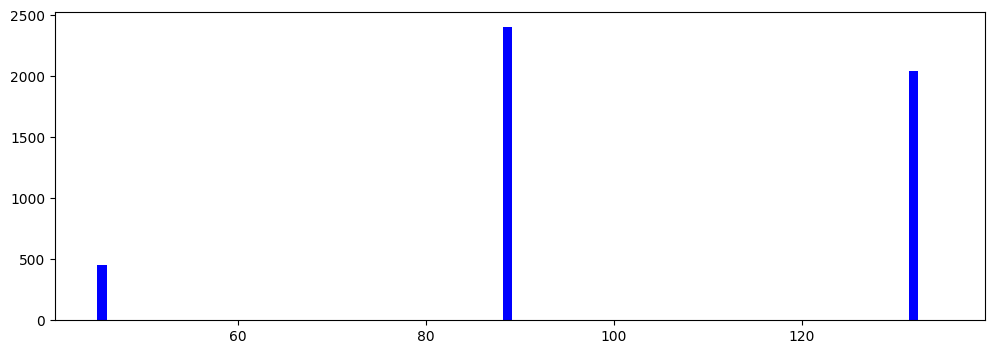

In [ ]:
num_of_bins = 25
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

Training data: 3137
Validation data: 785
Test data: 981


Text(0.5, 1.0, 'Validation Data')

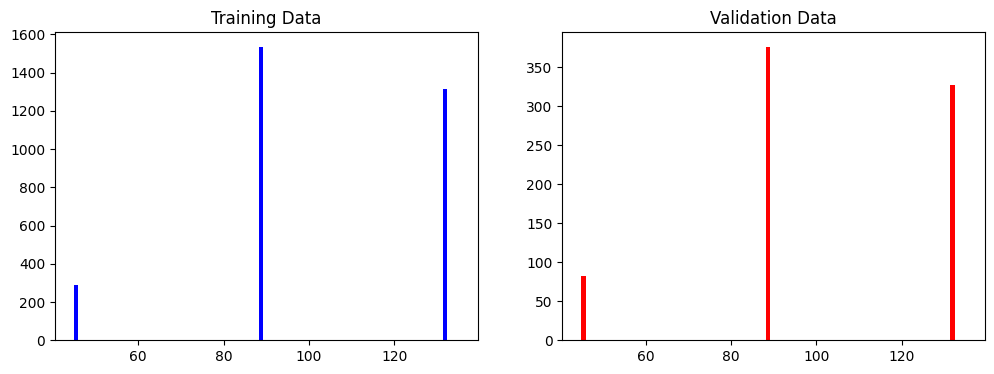

In [ ]:
# train : test = 0.8 : 0.2 비율로 split
X_train, X_valid, y_train, y_valid = train_test_split( image_paths,steering_angles, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
print("Training data: %d\nValidation data: %d\nTest data: %d" % (len(X_train), len(X_valid), len(X_test)))

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

In [ ]:
class NvidiaModel(nn.Module): # 모델 클래스 정의
    def __init__(self):
        super(NvidiaModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, kernel_size=5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, kernel_size=3),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ELU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(64 * 1 * 18, 100),  # Adjust the input features according to the output of the last Conv layer
            nn.ELU(),
            nn.Linear(100, 50),
            nn.ELU(),
            nn.Linear(50, 10),
            nn.ELU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# 모델 초기화
model = NvidiaModel()

# 옵티마이저 및 손실 함수 설정
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 252219


Training data: 3137
Validation data: 785
Test data: 785


Text(0.5, 1.0, 'Validation Data')

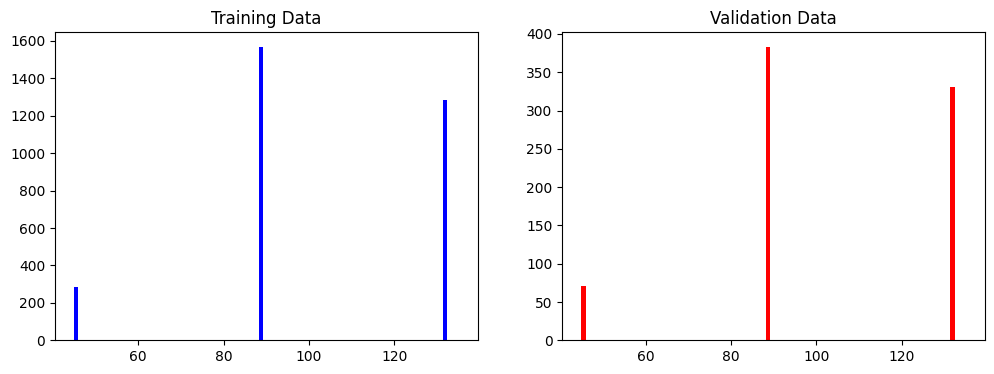

In [ ]:
# train : test = 0.8 : 0.2 비율로 split
X_train, X_valid, y_train, y_valid = train_test_split( image_paths,steering_angles, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
print("Training data: %d\nValidation data: %d\nTest data: %d" % (len(X_train), len(X_valid), len(X_valid)))

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

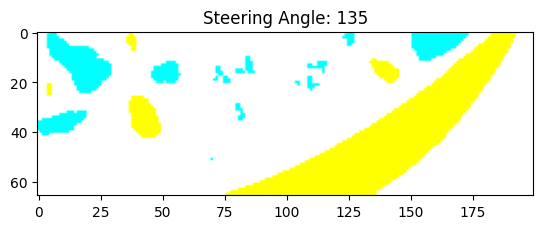

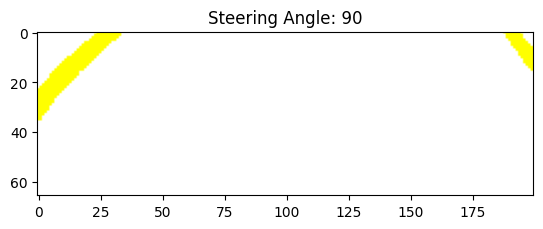

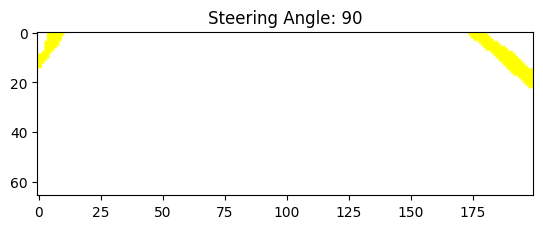

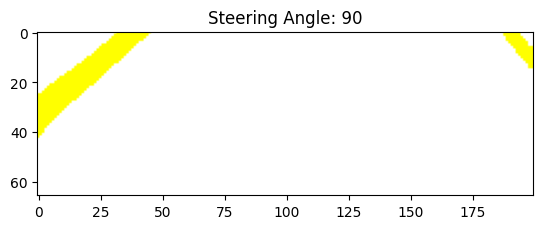

In [ ]:
transformations = transforms.Compose([
    transforms.Resize((66, 200)),
    transforms.ToTensor()
])
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, steering_angles, transform=None):
        self.image_paths = image_paths
        self.steering_angles = steering_angles
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        steering_angle = self.steering_angles[idx]

        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        return image, steering_angle

# 데이터 생성
train_dataset = CustomImageDataset(X_train, y_train, transform=transformations)
valid_dataset = CustomImageDataset(X_valid, y_valid, transform=transformations)
test_dataset = CustomImageDataset(X_test, y_test, transform=transformations)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

images, steering_angles = next(iter(test_loader))
for i in range(4):
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(f"Steering Angle: {steering_angles[i]}")
    plt.show()


In [ ]:
model_output_dir = "/content/drive/MyDrive/IOT/Model"
best_loss = float('inf')
history = {'train_loss': [], 'val_loss': []}
for epoch in range(10):
    model.train()
    train_losses = []
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())  # Unsqueeze labels for proper shape
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)

    model.eval()
    valid_losses = []
    with torch.no_grad():
        for images, labels in valid_loader:
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())  # Unsqueeze labels for proper shape
            valid_losses.append(loss.item())
    valid_loss = np.mean(valid_losses)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(valid_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

    # Validation loss가 작아지면 저장
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_output_dir, 'lane_navigation_check_F.pth'))
        print("Saved Best Model")

# 최종 모델 저장
torch.save(model.state_dict(), os.path.join(model_output_dir, 'lane_navigation_final_F.pth'))

# Save training history
history_path = os.path.join(model_output_dir, 'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history, f)

Epoch 1, Train Loss: 4088.5469, Validation Loss: 1328.2563
Saved Best Model
Epoch 2, Train Loss: 915.5450, Validation Loss: 842.8782
Saved Best Model
Epoch 3, Train Loss: 850.6055, Validation Loss: 836.4963
Saved Best Model
Epoch 4, Train Loss: 845.6314, Validation Loss: 847.1292
Epoch 5, Train Loss: 843.8451, Validation Loss: 835.6628
Saved Best Model
Epoch 6, Train Loss: 846.1383, Validation Loss: 845.1240
Epoch 7, Train Loss: 833.6478, Validation Loss: 817.2614
Saved Best Model
Epoch 8, Train Loss: 812.2559, Validation Loss: 822.7360
Epoch 9, Train Loss: 831.5094, Validation Loss: 900.2445
Epoch 10, Train Loss: 809.7321, Validation Loss: 779.6752
Saved Best Model


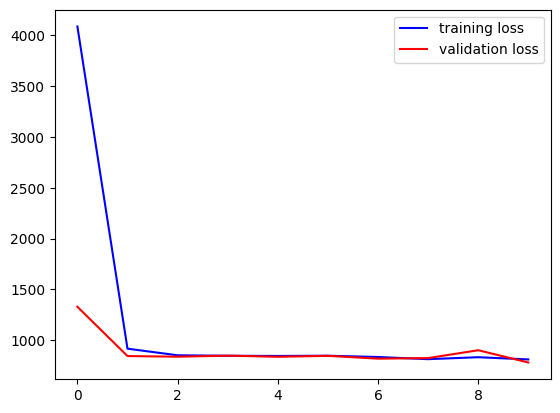

In [ ]:
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

history
plt.plot(history['train_loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
def summarize_prediction(Y_true, Y_pred):

    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)

    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()

def predict_and_summarize(X, Y, model):
    model.load_state_dict(torch.load(f'{model_output_dir}/lane_navigation_final_F.pth'))
    model.eval()
    Y_pred = []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data

            outputs = model(inputs)
            prediction = outputs.max(1, keepdim = True)[1]
            Y_pred.extend(outputs)


    Y_pred = torch.tensor(Y_pred)
    summarize_prediction(Y, Y_pred)
    return Y_pred

y_pred = predict_and_summarize(X_test, y_test, model)


mse       = 8.6e+02
r_squared = -1.28%



# ResNet 모델


In [ ]:
import os
import random
import fnmatch
import pickle


In [ ]:
# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

In [ ]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset

print( f'np.__version__: {np.__version__}' )
print( f'pytorch.__version__: {torch.__version__}' )

np.__version__: 1.25.2
pytorch.__version__: 2.3.0+cu121


In [ ]:
# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

In [ ]:
data_dir = "/content/drive/MyDrive/IOT/AddData/Data_Unzip/video"
file_list = os.listdir(data_dir)
image_paths = [] #이미지 경로를 저장하는 변수
steering_angles = [] #이미지 각도를 저장하는 변수
pattern = "*.png" #.png 확장자 가진 파일만 취급
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename)) #image_paths 리스트에 파일명을 추가한다.
        angle = int(filename[-7:-4]) #각도는 사진데이터에서 끝의 -7부터 -3까지만 분리한다.
     #예를들어 train_00006_090.png 파일명이라면 090만 분리하여 저장한다. .png도 파일명의 숫자로 포함 된다.
        steering_angles.append(angle) #steering_angles 리스트에 각도를 추가한다.

image_path: /content/drive/MyDrive/IOT/AddData/Data_Unzip/video/train_04389_135.png
steering_Angle: 135


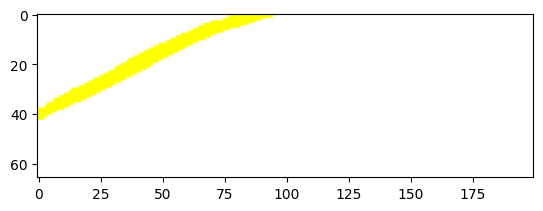

In [ ]:
image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

(array([1915.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        2661.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        4432.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        2726.0000]),
 array([0.0000, 5.4000, 10.8000, 16.2000, 21.6000, 27.0000, 32.4000,
        37.8000, 43.2000, 48.6000, 54.0000, 59.4000, 64.8000, 70.2000,
        75.6000, 81.0000, 86.4000, 91.8000, 97.2000, 102.6000, 108.0000,
        113.4000, 118.8000, 124.2000, 129.6000, 135.0000]),
 <BarContainer object of 25 artists>)

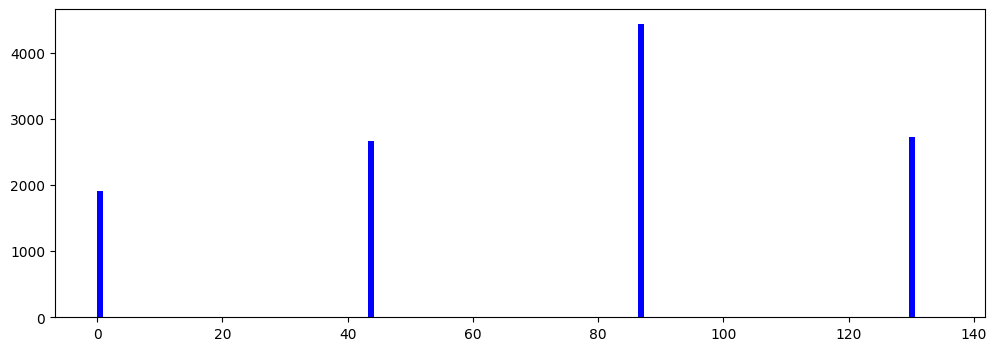

In [ ]:
num_of_bins = 25
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')


Training data: 7040
Validation data: 2347
Test data: 2347


Text(0.5, 1.0, 'Validation Data')

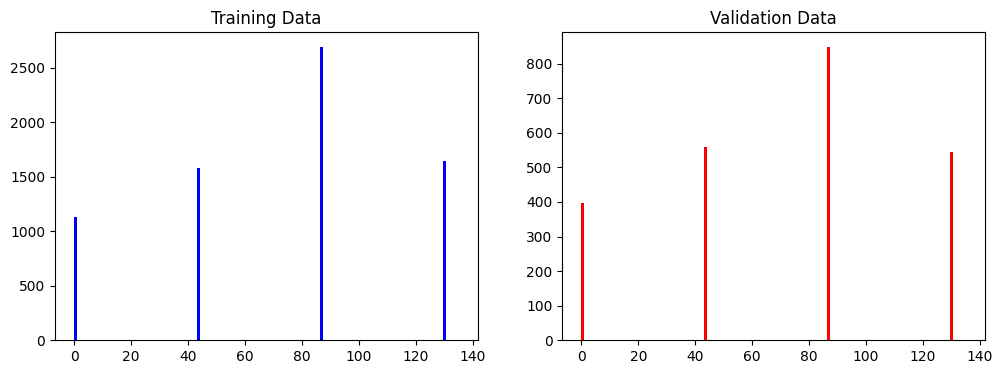

In [ ]:
# train : validation : test = 0.6 : 0.2 : 0.2 비율로 split
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, steering_angles, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Training data: %d\nValidation data: %d\nTest data: %d" % (len(X_train), len(X_valid), len(X_test)))
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

Training data: 7509
Validation data: 1878
Test data: 2347


'\n# train : test = 0.8 : 0.2 비율로 split\nX_train, X_valid, y_train, y_valid = train_test_split( image_paths,steering_angles, test_size=0.2)\nX_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)\nprint("Training data: %d\nValidation data: %d\nTest data: %d" % (len(X_train), len(X_valid), len(X_valid)))\n\nfig, axes = plt.subplots(1,2, figsize=(12,4))\naxes[0].hist(y_train, bins=num_of_bins, width=1, color=\'blue\')\naxes[0].set_title(\'Training Data\')\naxes[1].hist(y_valid, bins=num_of_bins, width=1, color=\'red\')\naxes[1].set_title(\'Validation Data\')\n'

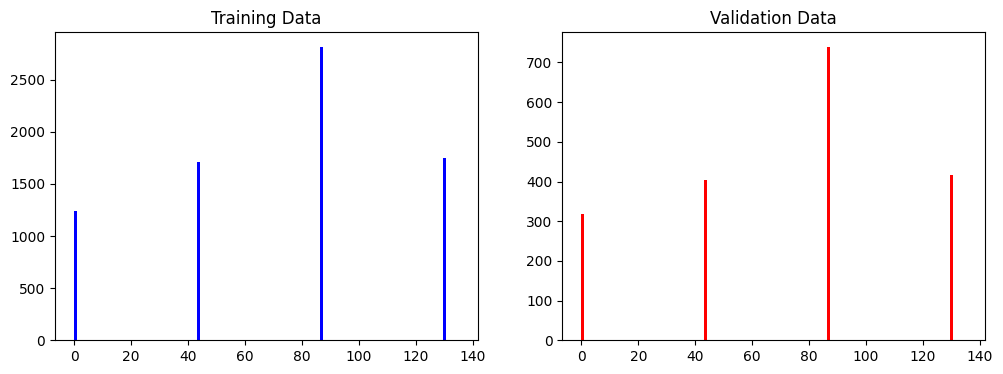

In [ ]:
# 전체 데이터를 훈련 및 검증 세트로 분할 (train : validation = 0.8 : 0.2)
X_train_valid, X_test, y_train_valid, y_test = train_test_split(image_paths, steering_angles, test_size=0.2, random_state=42)

# 훈련 및 검증 세트를 훈련 세트와 검증 세트로 분할 (train : validation = 0.8 : 0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42)

print("Training data: %d\nValidation data: %d\nTest data: %d" % (len(X_train), len(X_valid), len(X_test)))

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

In [ ]:
# ResNet 모델 초기화
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # 출력 클래스 수 1 (조향각 예측)

# 옵티마이저 및 손실 함수 설정
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # 학습률 1e-4로 변경
criterion = nn.MSELoss()

total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


Total parameters: 11177025


In [ ]:
transformations = transforms.Compose([
    transforms.Resize((66, 200)),
    transforms.ToTensor()
])

In [ ]:

class CustomImageDataset(Dataset):
    def __init__(self, image_paths, steering_angles, transform=None):
        self.image_paths = image_paths
        self.steering_angles = steering_angles
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        steering_angle = self.steering_angles[idx]

        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        return image, steering_angle

# 데이터 생성
train_dataset = CustomImageDataset(X_train, y_train, transform=transformations)
valid_dataset = CustomImageDataset(X_valid, y_valid, transform=transformations)
test_dataset = CustomImageDataset(X_test, y_test, transform=transformations)
train_loader = DataLoader(train_dataset, batch_size=64 , shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [ ]:
# 학습 시작
model_output_dir = "/content/drive/MyDrive/IOT/Model"
best_loss = float('inf')
history = {'train_loss': [], 'val_loss': []}
for epoch in range(10):  # 에폭 수 50으로 증가 -> 25
    model.train()
    train_losses = []
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)

    model.eval()
    valid_losses = []
    with torch.no_grad():
        for images, labels in valid_loader:
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            valid_losses.append(loss.item())
    valid_loss = np.mean(valid_losses)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(valid_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_output_dir, 'resnet_lane_navigation.pth'))
        print("Saved Best Model")

# 최종 모델 저장
torch.save(model.state_dict(), os.path.join(model_output_dir, 'resnet_lane_navigation_stop.pth'))

# Save training history
history_path = os.path.join(model_output_dir, 'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history, f)

Epoch 1, Train Loss: 0.1365, Validation Loss: 0.0325
Saved Best Model
Epoch 2, Train Loss: 0.0092, Validation Loss: 0.0043
Saved Best Model
Epoch 3, Train Loss: 0.0030, Validation Loss: 0.0022
Saved Best Model
Epoch 4, Train Loss: 0.0016, Validation Loss: 0.0016
Saved Best Model
Epoch 5, Train Loss: 0.0016, Validation Loss: 0.0020
Epoch 6, Train Loss: 0.0012, Validation Loss: 0.0014
Saved Best Model
Epoch 7, Train Loss: 0.0014, Validation Loss: 0.0014
Epoch 8, Train Loss: 0.0020, Validation Loss: 0.0014
Epoch 9, Train Loss: 0.0008, Validation Loss: 0.0014
Epoch 10, Train Loss: 0.0008, Validation Loss: 0.0014


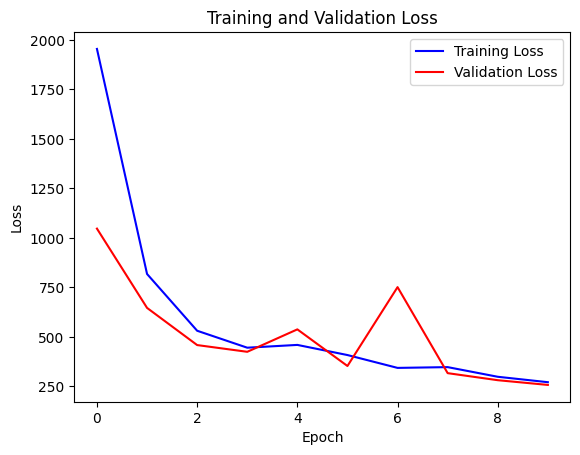

In [ ]:
history_path = os.path.join(model_output_dir, 'resnet_lane_navigation_history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

# 훈련 및 검증 손실값 시각화
plt.plot(history['train_loss'], color='blue')
plt.plot(history['val_loss'], color='red')
plt.legend(["Training Loss", "Validation Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()


In [ ]:
## ResNet 평가
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_performance(model, test_loader):
    model.eval()
    Y_true = []
    Y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            #inputs = inputs.to(device)
            #labels = labels.to(device)
            outputs = model(inputs)
            Y_true.extend(labels.cpu().numpy())
            Y_pred.extend(outputs.cpu().numpy())

    Y_true = np.array(Y_true)
    Y_pred = np.array(Y_pred)

    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)

    print(f'Mean Squared Error (MSE): {mse:.2f}')
    print(f'R-squared: {r_squared:.2%}')

    return mse, r_squared

# 모델 성능 평가
mse, r_squared = evaluate_performance(model, test_loader)

Mean Squared Error (MSE): 0.00
R-squared: 0.00%


## 데이터 추가


In [ ]:
import zipfile

zip_file=zipfile.ZipFile("/content/drive/MyDrive/IOT/AddData/videotest.zip")
zip_file.extractall("/content/drive/MyDrive/IOT/AddData/Data_Unzip")

In [ ]:
data_dir = "/content/drive/MyDrive/IOT/AddData/Data_Unzip/video"
file_list = os.listdir(data_dir)
image_paths = [] #이미지 경로를 저장하는 변수
steering_angles = [] #이미지 각도를 저장하는 변수
pattern = "*.png" #.png 확장자 가진 파일만 취급
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename)) #image_paths 리스트에 파일명을 추가한다.
        angle = int(filename[-7:-4]) #각도는 사진데이터에서 끝의 -7부터 -3까지만 분리한다.
     #예를들어 train_00006_090.png 파일명이라면 090만 분리하여 저장한다. .png도 파일명의 숫자로 포함 된다.
        steering_angles.append(angle) #steering_angles 리스트에 각도를 추가한다.

image_path: /content/drive/MyDrive/IOT/AddData/Data_Unzip/video/train_01956_045.png
steering_Angle: 45


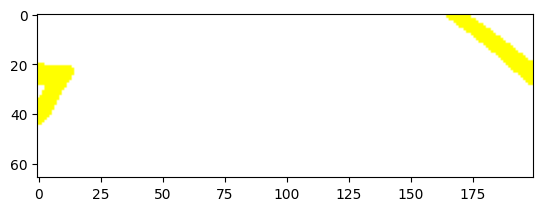

In [ ]:
image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

(array([3531.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        4986.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        8286.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        5079.0000]),
 array([0.0000, 5.4000, 10.8000, 16.2000, 21.6000, 27.0000, 32.4000,
        37.8000, 43.2000, 48.6000, 54.0000, 59.4000, 64.8000, 70.2000,
        75.6000, 81.0000, 86.4000, 91.8000, 97.2000, 102.6000, 108.0000,
        113.4000, 118.8000, 124.2000, 129.6000, 135.0000]),
 <BarContainer object of 25 artists>)

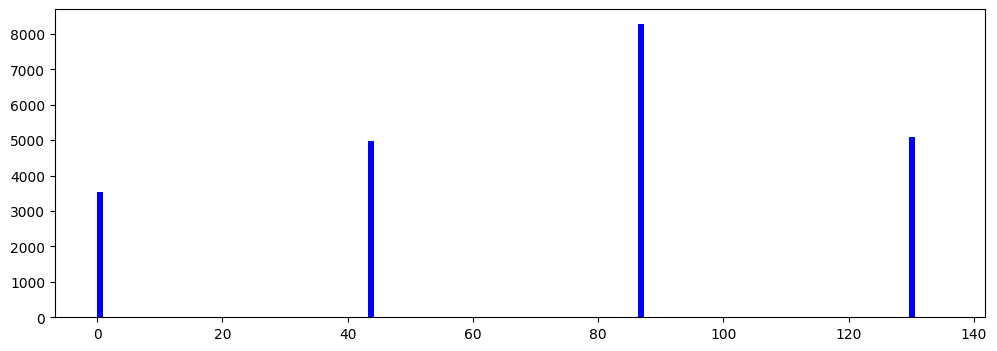

In [ ]:
num_of_bins = 25
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

In [ ]:
# 커스텀 데이터셋 클래스 정의
class LaneDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.png')]
        self.labels = [float(f.split('_')[-1].replace('.png', '')) for f in self.image_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_name)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

# 데이터 전처리 및 로더 설정
transform = transforms.Compose([
    transforms.Resize((66, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
data_dir = "/content/drive/MyDrive/IOT/AddData/Data_Unzip/video"
dataset = LaneDataset(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size

# 데이터셋이 비어있는지 확인
if train_size == 0 or valid_size == 0:
    raise ValueError("Train size or validation size is 0")

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# 미리 학습된 모델 불러오기
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model.load_state_dict(torch.load('/content/drive/MyDrive/IOT/Model/resnet_lane_navigation_F2.pth'))

# 손실 함수 및 최적화기 설정
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class LaneDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.png')]
        self.labels = [float(f.split('_')[-1].replace('.png', '')) for f in self.image_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_name)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((66, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_dir = "/content/drive/MyDrive/IOT/AddData/Data_Unzip/video"  # 데이터 경로 설정
dataset = LaneDataset(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)


In [ ]:
import numpy as np

# 학습 시작
model_output_dir = "/content/drive/MyDrive/IOT/Model"
best_loss = float('inf')
history = {'train_loss': [], 'val_loss': []}

num_epochs = 10  # 에폭 수 설정

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    model.eval()
    valid_losses = []
    with torch.no_grad():
        for images, labels in valid_loader:
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            valid_losses.append(loss.item())

    valid_loss = np.mean(valid_losses)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(valid_loss)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_output_dir, 'resnet_lane_navigation.pth'))
        print("Saved Best Model")

# 최종 모델 저장
torch.save(model.state_dict(), os.path.join(model_output_dir, 'resnet_lane_navigation_final_stop.pth'))

# 학습 히스토리 저장
import pickle
history_path = os.path.join(model_output_dir, 'resnet_lane_navigation_history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history, f)


Epoch 1, Train Loss: 1954.9798, Validation Loss: 1047.0351
Saved Best Model
Epoch 2, Train Loss: 817.8518, Validation Loss: 646.4602
Saved Best Model
Epoch 3, Train Loss: 531.0018, Validation Loss: 458.6298
Saved Best Model
Epoch 4, Train Loss: 445.3554, Validation Loss: 424.6020
Saved Best Model
Epoch 5, Train Loss: 459.4273, Validation Loss: 537.9221
Epoch 6, Train Loss: 408.2161, Validation Loss: 352.8991
Saved Best Model
Epoch 7, Train Loss: 343.2979, Validation Loss: 751.3637
Epoch 8, Train Loss: 347.2000, Validation Loss: 316.7341
Saved Best Model
Epoch 9, Train Loss: 298.4384, Validation Loss: 281.1277
Saved Best Model
Epoch 10, Train Loss: 271.0142, Validation Loss: 257.2668
Saved Best Model


In [ ]:
# ResNet 평가
from sklearn.metrics import mean_squared_error, r2_score
# data_loader
def evaluate_performance(model, valid_loader):
    model.eval()
    Y_true = []
    Y_pred = []
    with torch.no_grad():
        for inputs, labels in valid_loader :
            outputs = model(inputs)
            Y_true.extend(labels.numpy())
            Y_pred.extend(outputs.numpy())

    Y_true = np.array(Y_true)
    Y_pred = np.array(Y_pred)

    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)

    print(f'Mean Squared Error (MSE): {mse:.2f}')
    print(f'R-squared: {r_squared:.2%}')

    return mse, r_squared

# 모델 성능 평가
mse, r_squared = evaluate_performance(model, valid_loader)

Mean Squared Error (MSE): 257.25
R-squared: 0.00%


## 모델끼리 병합하기

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class CombinedResNet(nn.Module):
    def __init__(self, resnet1, resnet2, num_classes=1):
        super(CombinedResNet, self).__init__()
        self.resnet1 = nn.Sequential(
            resnet1.conv1,
            resnet1.bn1,
            resnet1.relu,
            resnet1.maxpool,
            resnet1.layer1,
            resnet1.layer2,
            resnet1.layer3,
            resnet1.layer4,
            resnet1.avgpool,
        )

        self.resnet2 = nn.Sequential(
            resnet2.conv1,
            resnet2.bn1,
            resnet2.relu,
            resnet2.maxpool,
            resnet2.layer1,
            resnet2.layer2,
            resnet2.layer3,
            resnet2.layer4,
            resnet2.avgpool,
        )

        self.fc = nn.Linear(512 * 2, num_classes)

    def forward(self, x1, x2):
        out1 = self.resnet1(x1)
        out1 = torch.flatten(out1, 1)

        out2 = self.resnet2(x2)
        out2 = torch.flatten(out2, 1)

        combined_out = torch.cat((out1, out2), dim=1)
        final_out = self.fc(combined_out)
        return final_out

# 모델 로드 및 결합
resnet1 = models.resnet18(weights=None)
resnet2 = models.resnet18(weights=None)

resnet1.fc = nn.Identity()  # Fully connected layer 제거
resnet2.fc = nn.Identity()  # Fully connected layer 제거

# strict=False 옵션으로 state dict를 로드
resnet1.load_state_dict(torch.load('/content/drive/MyDrive/IOT/Model/resnet_lane_navigation_F2.pth', map_location='cpu'), strict=False)
resnet2.load_state_dict(torch.load('/content/drive/MyDrive/IOT/Model/resnet_lane_navigation_stop.pth', map_location='cpu'), strict=False)

combined_model = CombinedResNet(resnet1, resnet2, num_classes=1)

# 결합된 모델 저장
torch.save(combined_model.state_dict(), '/content/drive/MyDrive/IOT/Model/combined_resnet_model_omg.pth')

# 저장된 모델 불러오기
combined_model.load_state_dict(torch.load('/content/drive/MyDrive/IOT/Model/combined_resnet_model_omg.pth', map_location='cpu'))


<All keys matched successfully>